### Math Basis:

#### Time $(t)$:
The function below calculates time in days with 01/01/2000 as the base date.

*The error inside an interval of 1000 years before or after 01/01/2000 for the position $M$ of the sun is 1 arcmin, which is $\sim 0.02\textdegree$*

#### Eccentric Anomaly $(E)$:
From Kepler's equations:
$$ M = E - e \sin{E} $$
Rewriting it:
$$ E = M + e \sin{E} $$
Considering both sides of the equation as functions of the eccentric anomaly $E$:

$ f(E) = E $

$ g(E) = M + e \sin{E} $

Finding the point $E$ where $f(E) = g(E)$ will give the eccentric anomaly $E$:
$$ f(E) - g(E) = 0 $$
The method that will be used to find the root of the expression above is known as **Newton Rapshon's** method.

To use *Newton Raphson's* method to find the root of a function $h(x)$, the derivative of the function $\frac{dh(x)}{dx}$ is needed.
$$h(x) = f(E) - g(E)$$
Using values of the functions $f(E)$ and $g(E)$:

$$h(x) = E - M - e \sin{E}$$
$$\frac{dh(x)}{dx} = 1 - e \cos(E)$$

With the functions above it is possible to approximate the root of $h(x)$ and, therefore, get the value of $E$ that satisfies Kepler's equation.

#### True anomaly $(\nu)$:
Here's the expression to calculate the true anomaly:
$$\tan{\frac{\nu}{2}}=\sqrt{\frac{1 + e}{1 - e}}\tan{\frac{E}{2}}$$
It can be rewritten as:
$$\nu = 2 \cdot \arctan{\left( {\sqrt{\frac{1 + e}{1 - e}}\tan{\frac{E}{2}}} \right)}$$

#### Heliocentric distance $(r)$:
The expression below can be used to calculate the heliocentric distance $r$ using the *true anomaly* $\nu$, the semi-major axis of the orbit $a$ and the eccentricitty $e$.
$$r = \frac{a (1 - e^2)}{1 + e \cos{\nu}}$$
The heliocentric distance can also be expressed in terms of the eccentric anomaly $E$:
$$r = a (1 - e \cos{E})$$

#### Barycenter:
The center of mass of a system can be calculated with a weighted average of $n$ particles of mass $M_k$ in a position $P_k$:
$$P_{cm} = \frac{1}{M_t}\sum_{i=0}^{n} M_k \cdot P_k$$
Where $M_t$ is the total mass of the system:
$$M_t = \sum_{i=0}^{n} M_k$$
Considering 3-dimensional vectors $P_k$ and $P_{cm}$:
$$P_{cm} = [x_{cm}, y_{cm}, z_{cm}]$$
$$P_k = [x_k, y_k, z_k]$$
Each axis can be evaluated individually:
$$x_{cm} = \frac{1}{M_t}\sum_{i=0}^{n} M_k \cdot x_k$$
$$y_{cm} = \frac{1}{M_t}\sum_{i=0}^{n} M_k \cdot y_k$$
$$z_{cm} = \frac{1}{M_t}\sum_{i=0}^{n} M_k \cdot z_k$$
Calculating star distance from barycenter in kilometers $\Delta_{(km)}$, where $P_s$ is the star's position.:
$$\Delta_{(km)} = |P_{cm} - P_s|$$
Dividing the distance $\Delta_{(km)}$ by the star's radius $R_s$ results in $\Delta$:
$$\Delta = \frac{\Delta_{(km)}}{R_s}$$
Then, if $\Delta > 1$, the barycenter is outside the star, otherwise it is inside.

### Execution:

In [231]:
# Importing modules
import matplotlib.pyplot as plot;
import pandas as pd;
import numpy as np;

In [232]:
# Converts radians to angle rounded to third decimal case.
def ToAngle(value): return np.round(value * 180 / np.pi, 3);

# Adjusts angle to be between 0 and 2 pi. Parameter in radians.
def AdjustAngle(angle):
    newAng = angle;
    
    k = angle // (2 * np.pi);
    newAng += -k * 2 * np.pi;

    return newAng;

#### 1. Time:

In [233]:
# Calculates times in days from 01/01/2000.
def TimeInDays(date, time):
    # Date format: dd/mm/yyyy
    # Time format: hh:mm
    
    date_, time_ = [], [];
    for num in date.split("/"): date_.append(int(num));
    for num in time.split(":"): time_.append(int(num));
    
    d, m, y = date_;
    h, mi = time_;

    # Calculating date time in days
    dateDays = 367 * y - int(7 * (y + int((m + 9) / 12)) / 4) + int(275 * m / 9) + d - 730530;
    # Calculating hours and minutes time in days
    timeDays = h / 24 + mi / 1440;
    
    # Truncating to the third decimal case and returning value.
    return round(dateDays + timeDays, 3); 

In [234]:
# Calculating time to use in parameters.
daysTime = TimeInDays("10/11/2673", "09:40"); print(daysTime);

246128.403


#### 2. Orbital parameters $(\Omega, i, \varpi, a, e, M)$ and masses $(m)$:

In [235]:
# Gets parameters from data collected using pd.read_csv.
def GetParameters(data, time):
    # Parameters are split in a and b from linear function parameters.
    # Order of parameters: omega, i, w, a, e, M.
    
    arr = data.to_numpy().transpose();

    # Creating array with parameters a set time using coefficients of function a and b. 
    # Example: P(t) = at + b.
    # Coefficients a are odd, b are even.
    arr_ = np.zeros((int(arr.shape[0] / 2), arr.shape[1]));
    for i in range(0, len(arr), 2): 
        curIdx = int(i / 2);
        arr_[curIdx] = arr[i + 1] * time + arr[i];

        if (i == 6 or i == 8): continue; # Ignoring non-angular parameters (a and e).
        
        k = arr_[curIdx] // 360;
        arr_[curIdx] += -k * 360;
        
        arr_[curIdx] *= np.pi / 180;

    return arr_;

In [236]:
# Collecting parameters from csv files.
paraData = pd.read_csv("parameters.csv", sep=r"\s+", header=None);
massData = pd.read_csv("masses.csv", sep=r"\s+", header=None)
rawParameters = GetParameters(paraData, daysTime);

omega, i, w, a, e, M = rawParameters;
m_ = massData.to_numpy().transpose()[0]; 

# Calculating star parameters individually.
starPos  = np.zeros(3);
starMass = m_[0];

m = m_[1:]; # Separating star mass from planets masses 

# Constants
auKm       = 149597870.7;
starRadius = 696340;
numBodies  = len(M);

for k, parameter in enumerate(rawParameters):
    if (k == 3 or k == 4): print(np.round(parameter, 5)); continue;
    print(ToAngle(parameter));

[ 56.32   82.749   0.     54.753 107.268 119.545  77.441 139.207]
[7.017 3.401 0.    1.845 1.265 2.462 0.778 1.707]
[ 31.621  58.297 294.531 293.712 277.927 346.72  104.184 271.363]
[ 0.3871   0.72333  1.       1.52369  5.20256  9.55475 19.1779  30.06641]
[0.20577 0.00645 0.01643 0.09402 0.0496  0.05321 0.04915 0.00914]
[128.396 177.759 300.265 114.999 309.547 268.541 148.644 295.823]


#### 3. Eccentric anomaly $(E)$:

In [237]:
# Newton Raphson method for finding roots of functions.
def NewtonRaphson(f, df, z0, maxIter, rootRange):
    z = z0;
    for i in range(maxIter):
        deriv = df(z);
        if (deriv == 0): deriv = rootRange;
        if (abs(f(z).real) <= rootRange): return z;

        z -= f(z) / deriv; 
        
    return None; # No root was found.

# Finds the eccentric anomaly given M and e.
def KeplerEquation(M, e):
    k  = lambda E: E - M - e * np.sin(E);
    dk = lambda E: 1 - e * np.cos(E);

    # Finding E value when E - M - e sin(E) = 0 and adjusting it.
    return AdjustAngle(NewtonRaphson(k, dk, M, 50, 5e-6));

In [238]:
# Calculating eccentric anomaly 
E = np.zeros(numBodies);
for k in range(numBodies): E[k] = KeplerEquation(M[k], e[k]);

print(ToAngle(E));

[136.51  177.773 299.445 119.679 307.286 265.502 150.05  295.35 ]


#### 4. True anomaly $(\nu)$:

In [239]:
# Calculates true anomaly with eccentric anomaly and eccentricity.
def TrueAnomaly(E, e):  
    return AdjustAngle(2 * np.atan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2)));

In [240]:
# Calculating true anomaly 
v = TrueAnomaly(E, e); print(ToAngle(v)); 

[144.125 177.787 298.622 124.261 304.99  262.468 151.428 294.876]


#### 5. Distances $(au)$:

In [241]:
# Calculates heliocentric distance r from planet.
def Distance(E, e, a): return a * (1 - e * np.cos(E));
def Distance_(v, e, a): return a * (1 - e * e) / (1 + e * np.cos(v));

In [242]:
# Calculating heliocentric distance (au)
r = Distance(E, e, a); print(np.round(r, 4));

[ 0.4449  0.728   0.9919  1.5946  5.0462  9.5946 19.9946 29.9488]


#### 6. Cartesian coordinates:

In [243]:
# Calculates x, y, z positions of planets in cartesian coordinates. Parameters should be numpy arrays.
# r is in kilometers
def CartesianCoordinates(r, omega, w, v, i):
    x = r * (np.cos(omega) * np.cos(w + v) - np.sin(omega) * np.sin(w + v) * np.cos(i));
    y = r * (np.sin(omega) * np.cos(w + v) + np.cos(omega) * np.sin(w + v) * np.cos(i));
    z = r * (np.sin(w + v) * np.sin(i));

    return x, y, z;

In [244]:
# Calculating cartesian coordinates (km):
x, y, z = CartesianCoordinates(r * auKm, omega, w, v, i); 
print(f"X: {x}\nY: {y}\nZ: {z}");

X: [-4.08832526e+07  8.18265748e+07 -8.89854486e+07 -9.20721977e+07
  6.54862570e+08  1.41761461e+09  2.66612793e+09  4.33593461e+09]
Y: [-5.25132422e+07 -7.16676117e+07 -1.18748294e+08  2.19971727e+08
 -3.75381143e+08  2.17329010e+08 -1.35544516e+09 -1.12654017e+09]
Z: [   603100.49675277  -5362076.45593723        -0.
   6512541.21892351 -11345349.02922766 -57634186.48061717
 -39339566.58548795 -59012681.97798125]


#### 7. Eliptic coordinates:

In [245]:
# Calculate l, b positions of planets in heliocentric ecliptic coordinates. Parameters should be numpy arrays.
def EclipticCoordinates(x, y, z):
    l = np.atan(y / x);
    b = np.atan(z / np.sqrt(x * x + y * y));

    return AdjustAngle(l), b;

In [246]:
# Calculating heliocentric ecliptic coordinates
l, b = EclipticCoordinates(x, y, z); 
print(f"l: {ToAngle(l)}\nb: {ToAngle(b)}");

l: [ 52.098 318.787  53.154 292.712 330.178   8.716 333.051 345.436]
b: [ 0.519 -2.822 -0.     1.564 -0.861 -2.301 -0.754 -0.755]


#### 8. Barycenter coordinates:

In [247]:
# Calculates baricenter of planets in the system, parameters should be numpy arrays.
def Barycenter(starMass, m, x, y, z):
    totalMass = np.sum(m) + starMass;
    
    xb = np.sum(m * x) / totalMass;
    yb = np.sum(m * y) / totalMass;
    zb = np.sum(m * z) / totalMass;

    return np.array([xb, yb, zb]);

# Calculates distance from star and barycenter. Returns distance and distance / star radius.
def DeltaBarycenter(Pb, Ps, Rs): 
    deltaBarycenter = np.linalg.norm(Pb - Ps); 
    
    return deltaBarycenter, deltaBarycenter / Rs;

In [248]:
# Calculating barycenter (km)
barycenter = Barycenter(starMass, m, x, y, z); print(np.round(barycenter, 6));

[1368024.373109 -413307.052378  -32026.788123]


#### 9. Barycenter delta $(\Delta)$:

In [249]:
deltaKm, delta = DeltaBarycenter(barycenter, starPos, starRadius); print(np.round(deltaKm, 6), np.round(delta, 6));

1429454.13362 2.052811


#### 10. Positions Plot:

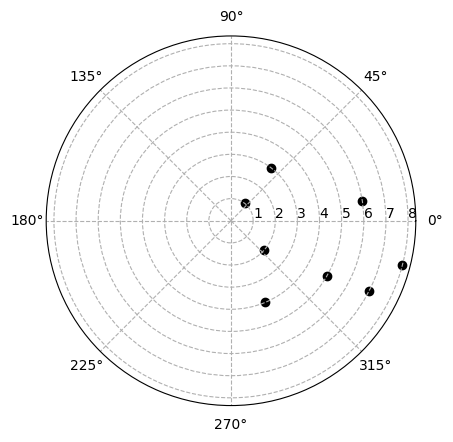

In [250]:
# Plotting angular positions
fig, ax = plot.subplots(subplot_kw={'projection': 'polar'});
ax.scatter(l, range(1, numBodies + 1), c='k');

ax.set_rlabel_position(0);
plot.grid(linestyle="--");
fig.savefig("angPositions.png");

plot.show();

### Prints for latex tables code:

In [251]:
# List of planet names.
planetNames = ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"];
indexes     = range(1, len(planetNames) + 1);

In [252]:
# Printing orbital parameters for latex code.
orbitalParameters = [];

# Adding indexes and planet names
orbitalParameters.append(indexes);
orbitalParameters.append(planetNames);

for j, parameter in enumerate(rawParameters):
    # Ignoring non-angle parameters (a and e).
    if (j == 3 or j == 4): orbitalParameters.append(np.round(parameter, 6)); continue;
    orbitalParameters.append(ToAngle(parameter));

calculatedParameters = [E, v, r];
for j,_ in enumerate(calculatedParameters):
    if (j == 2): orbitalParameters.append(np.round(r, 6)); continue; # Rounding distance in au
    orbitalParameters.append(ToAngle(calculatedParameters[j]));
 
arr = np.array(orbitalParameters).transpose();
for j,_ in enumerate(arr):
    for k,_ in enumerate(arr[j]):
        if (k == len(arr[j]) - 1): end_ = " \\\\ \n"; 
        else: end_ = " & ";
            
        print(arr[j][k], end=end_);

1 & Mercury & 56.32 & 7.017 & 31.621 & 0.387098 & 0.205773 & 128.396 & 136.51 & 144.125 & 0.444887 \\ 
2 & Venus & 82.749 & 3.401 & 58.297 & 0.72333 & 0.006453 & 177.759 & 177.773 & 177.787 & 0.727994 \\ 
3 & Earth & 0.0 & 0.0 & 294.531 & 1.0 & 0.016426 & 300.265 & 299.445 & 298.622 & 0.991925 \\ 
4 & Mars & 54.753 & 1.845 & 293.712 & 1.523688 & 0.094024 & 114.999 & 119.679 & 124.261 & 1.594625 \\ 
5 & Jupiter & 107.268 & 1.265 & 277.927 & 5.20256 & 0.049598 & 309.547 & 307.286 & 304.99 & 5.046242 \\ 
6 & Saturn & 119.545 & 2.462 & 346.72 & 9.55475 & 0.053208 & 268.541 & 265.502 & 262.468 & 9.594618 \\ 
7 & Uranus & 77.441 & 0.778 & 104.184 & 19.177895 & 0.049152 & 148.644 & 150.05 & 151.428 & 19.994646 \\ 
8 & Neptune & 139.207 & 1.707 & 271.363 & 30.066414 & 0.009135 & 295.823 & 295.35 & 294.876 & 29.948818 \\ 


In [253]:
# Printing cartesian and eliptic coordinates for latex code.
allCoordinates = [];

allCoordinates.append(indexes);
allCoordinates.append(planetNames);

coordList, angCoordList = [x, y, z], [l, b];
for j,_ in enumerate(coordList): allCoordinates.append(coordList[j]);
for j,_ in enumerate(angCoordList): allCoordinates.append(ToAngle(angCoordList[j]));
    
arr = np.array(allCoordinates).transpose();
for j,_ in enumerate(arr):
    for k,_ in enumerate(arr[j]):
        if (k == len(arr[j]) - 1): end_ = " \\\\ \n"; 
        else: end_ = " & ";

        if (k > 1 and k < 5): print(int(arr[j][k].astype(float)), end=end_); continue;
        print(arr[j][k], end=end_);

1 & Mercury & -40883252 & -52513242 & 603100 & 52.098 & 0.519 \\ 
2 & Venus & 81826574 & -71667611 & -5362076 & 318.787 & -2.822 \\ 
3 & Earth & -88985448 & -118748294 & 0 & 53.154 & -0.0 \\ 
4 & Mars & -92072197 & 219971726 & 6512541 & 292.712 & 1.564 \\ 
5 & Jupiter & 654862570 & -375381142 & -11345349 & 330.178 & -0.861 \\ 
6 & Saturn & 1417614608 & 217329010 & -57634186 & 8.716 & -2.301 \\ 
7 & Uranus & 2666127929 & -1355445161 & -39339566 & 333.051 & -0.754 \\ 
8 & Neptune & 4335934606 & -1126540170 & -59012681 & 345.436 & -0.755 \\ 
